In [1]:
import numpy as np
import matplotlib.pylab as plt
import Functions as F
from astropy.cosmology import Planck15 as Cosmo_AstroPy
from colossus.cosmology import cosmology
import colossus.halo.mass_adv as massdefs
import pickle
from colossus.lss import mass_function
from scipy.integrate import cumtrapz
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
cosmology.setCosmology("millennium")
from scipy.interpolate import interp1d,interp2d
from scipy.integrate import simps
from fast_histogram import histogram2d
import pickle

Cosmo = cosmology.getCurrent()
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dM^-1
h = Cosmo.h
h_3 = h*h*h


Override =\
{\
'M10':11.95,\
'SHMnorm10':0.032,\
'beta10':1.61,\
'gamma10':0.54,\
'M11':0.4,\
'SHMnorm11':-0.02,\
'beta11':-0.6,\
'gamma11':-0.1\
}

AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':True,\
'G18_notSE':False,\
'Lorenzo18':False,\
'Moster': False,\
'z_Evo':True,\
'Scatter': 0.11,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT':False,\
'PFT1': False,\
'PFT2': False,\
'PFT3': False\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
 'SFR_Model': 'S15'\
}

In [4]:
import matplotlib as mpl

mpl.rcParams['font.size']=25
mpl.rcParams['figure.figsize']=(16,16)
#mpl.rcParams['xtick.minor.visible']=True
mpl.rcParams['axes.linewidth']= 3.
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
mpl.rcParams['axes.titlepad'] = 20 

In [5]:
def make_mock(z, Lbox):
    
    Vol = (Lbox/h)**3
    halos_in = np.arange(11,16,0.1)
    haloMF = HMF_fun(halos_in,z)
    
    step = halos_in[1]-halos_in[0]
    Ncum=Vol*(np.cumsum((haloMF*h_3*step)[::-1])[::-1])
    f = interp1d(Ncum,halos_in)
    array_cumul=np.arange(min(Ncum),max(Ncum))
    halos=f(array_cumul)[::-1]
    
    mstar_cen = F.DarkMatterToStellarMass(halos, z, Paramaters, ScatterOn=True)
    mgas_cen = F.GetGasMass(mstar_cen, z, halos,Paramaters['SFR_Model'])
    SFR_cen = F.StarFormationRate(mstar_cen,z, Paramaters['SFR_Model'], ScatterOn=True)
    
    return mstar_cen,mgas_cen,SFR_cen,halos

In [6]:
max_stars = 12.5; min_stars = 9; bins_stars=0.1
max_gas = 12; min_gas=6; bins_gas=0.1
max_sfr = 5 ; min_sfr = -8; bins_sfr =0.05
max_ssfr = 5 ;min_ssfr = -15; bins_ssfr =0.05
max_ssfr_MS = 2.5; min_ssfr_MS = -3; bins_ssfr_MS = 0.05
max_mu =0.; min_mu =-3; bins_mu=0.1

mstar_bins = np.arange(min_stars,max_stars,bins_stars)
mgas_bins = np.arange(min_gas,max_gas,bins_gas)
sfr_bins = np.arange(min_sfr,max_sfr,bins_sfr)
ssfr_bins = np.arange(min_ssfr,max_ssfr,bins_ssfr)
ssfr_bins_MS = np.arange(min_ssfr_MS,max_ssfr_MS,bins_ssfr_MS)
mu_bins = np.arange(min_mu,max_mu,bins_mu)

mstar_bins_new = mstar_bins[1:]-bins_stars/2.
mgas_bins_new = mgas_bins[1:]-bins_gas/2.
sfr_bins_new = sfr_bins[1:]-bins_sfr/2.
ssfr_bins_new = ssfr_bins[1:]-bins_ssfr/2.
ssfr_bins_MS_new = ssfr_bins_MS[1:] -bins_ssfr_MS/2.
mu_bins_new = mu_bins[1:]-bins_mu/2.

In [7]:
burst_params =\
{\
 'delay':True,\
 'burst_law': 'Hopkins',\
 'total_time_yr': 1.5e9,\
  'tburst_yr' :1.e8
 } #delay is whether you account for satellite initialization at the appropriate z. Set 'True' to properly acount for it.
Lbox=250
#z=2


In [12]:
SFR = np.load('./quick_output/SFRS15z2.5.npy')
sSFR = np.load('./quick_output/sSFRS15z2.5.npy')
sSFR_MS = np.load('./quick_output/sSFR_MSS15z2.5.npy')
mgas = np.load('./quick_output/mgasS15z2.5.npy')


SFR_hopkins = np.load('./quick_output/SFRS15z2.5_hopkins.npy')
sSFR_hopkins = np.load('./quick_output/sSFRS15z2.5_hopkins.npy')
sSFR_MS_hopkins = np.load('./quick_output/sSFR_MSS15z2.5_hopkins.npy')
mgas_hopkins = np.load('./quick_output/mgasS15z2.5_hopkins.npy')

In [26]:
SFR = np.load('./quick_output/SFRS15z2.0.npy')
sSFR = np.load('./quick_output/sSFRS15z2.0.npy')
sSFR_MS = np.load('./quick_output/sSFR_MSS15z2.0.npy')
mgas = np.load('./quick_output/mgasS15z2.0.npy')


SFR_hopkins = np.load('./quick_output/SFRS15z2.0_hopkins.npy')
sSFR_hopkins = np.load('./quick_output/sSFRS15z2.0_hopkins.npy')
sSFR_MS_hopkins = np.load('./quick_output/sSFR_MSS15z2.0_hopkins.npy')
mgas_hopkins = np.load('./quick_output/mgasS15z2.0_hopkins.npy')

In [24]:
SFR = np.load('./quick_output/SFRS15z1.npy')
sSFR = np.load('./quick_output/sSFRS15z1.npy')
sSFR_MS = np.load('./quick_output/sSFR_MSS15z1.npy')
mgas = np.load('./quick_output/mgasS15z1.npy')


SFR_hopkins = np.load('./quick_output/SFRS15z1_hopkins.npy')
sSFR_hopkins = np.load('./quick_output/sSFRS15z1_hopkins.npy')
sSFR_MS_hopkins = np.load('./quick_output/sSFR_MSS15z1_hopkins.npy')
mgas_hopkins = np.load('./quick_output/mgasS15z1_hopkins.npy')

In [27]:
sSFR_MS.shape

(10, 34, 109)

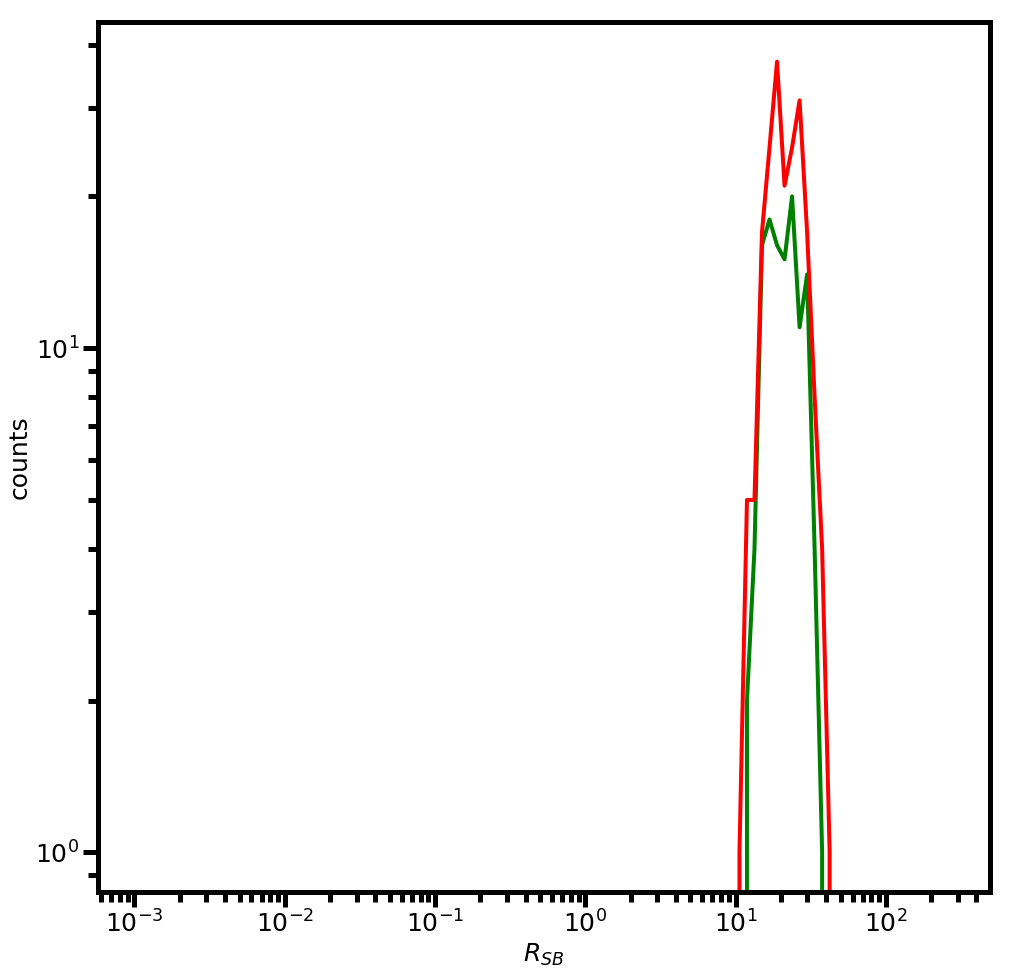

In [32]:
massCut_up = 10.8
massCut_low =11.2

b = np.ma.masked_inside(mstar_bins_new, massCut_low, massCut_up).mask

sSFR_burst_MS =np.zeros(sSFR_MS[0][b].shape[1])
for  i  in range(len(sSFR[0][b])):
    sSFR_burst_MS = sSFR_burst_MS + sSFR_MS[0][b][i]

sSFR_burst_MS_hopkins =np.zeros(sSFR_MS_hopkins[1][b].shape[1])
for  i  in range(len(sSFR[0][b])):
    sSFR_burst_MS_hopkins = sSFR_burst_MS_hopkins + sSFR_MS_hopkins[0][b][i]
    
plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS_hopkins, color='green',label='hopkins',lw=4)
plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS, color = 'red',label='sargent+schreiber',lw=4)
plt.ylabel('counts')
plt.xlabel('$R_{SB}$')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(-1,2)
#plt.savefig('/home/lz1f17/Pictures/SF_mergers/bursts.png')

In [34]:
array_times_out = np.array([tb*0.01,tb*0.05,tb*0.1,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75])#,tb])             



In [74]:
massCut_up = 10.8
massCut_low =11.2

b = np.ma.masked_inside(mstar_bins_new, massCut_low, massCut_up).mask

In [32]:
cov = np.array([[1,0.8],[0.8,2]])
mean=[0,0]
g = 10**np.random.multivariate_normal(mean,cov, size=10000)
bins = 10**np.arange(-5,5,0.2)
hist = np.histogram2d(g[:,0],g[:,1], bins=(bins,bins))[0]

In [42]:
    mstar_cen,mgas_cen,SFR_cen,halos = make_mock(cosmo_z_out[j],Lbox)
    #mask_mock = np.ma.masked_inside(mstar_cen, massCut_low, massCut_up).mask
    #SFR_mock = SFR_cen[mask_mock]  
    #mstar_mock = mstar_cen[mask_mock]
    SFR_MS_mean = F.StarFormationRate(mstar_cen,cosmo_z_out[j], Paramaters['SFR_Model'], ScatterOn=False)
    #sSFR_MS_mock = SFR_mock-SFR_MS_mean  #log
    sSFR_MS_mock = SFR_cen/SFR_MS_mean
    
    hist = np.histogram2d(mstar_cen, sSFR_MS_mock, bins =(mstar_bins,ssfr_bins_MS))[0]

In [47]:
sSFR_MS.shape

(10, 34, 109)

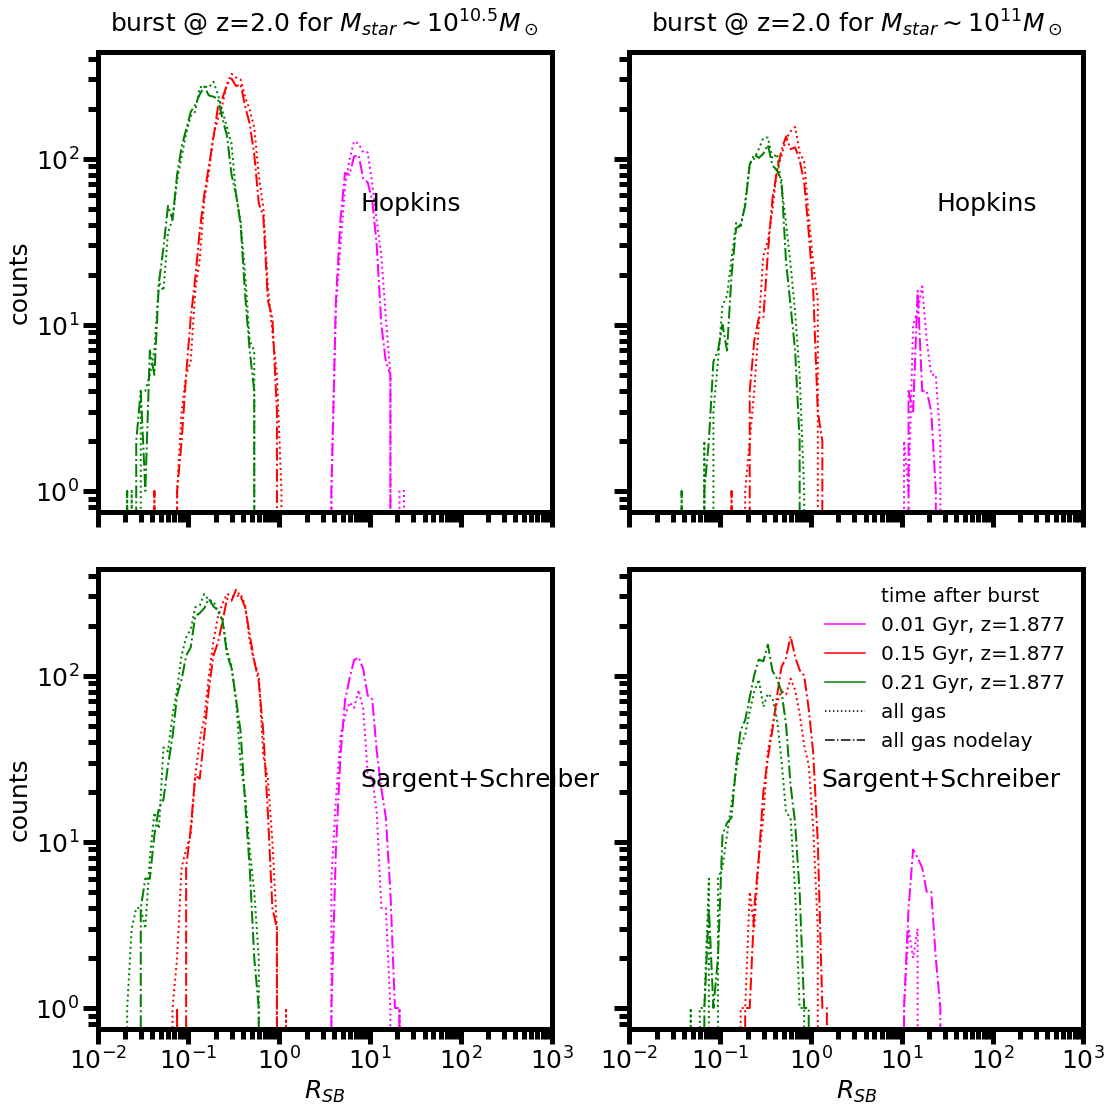

In [38]:
z=2.0
Lbox=250
a=50000

sSFR_MS = np.load('./quick_output/sSFR_MSS15z'+str(z)+'.npy')
tb=1. #Gyr
array_times_out = np.array([tb*0.01,tb*0.05,tb*0.1,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75])#,tb])             


cosmo_times_out = Cosmo.lookbackTime(z)-array_times_out
cosmo_z_out = Cosmo.lookbackTime(cosmo_times_out, inverse=True)

js=[0,3,5]
cosmo_z_out = np.array([cosmo_z_out[0],cosmo_z_out[3],cosmo_z_out[5]])

massCut_up = [10.7,11.2]
massCut_low = [10.3,10.8]
cols = ['magenta','red','green','navy','pink']
fileshop = ['./quick_output/sSFR_MSS15z2.0_hopkins_fgas_all.npy','./quick_output/sSFR_MSS15z2.0_hopkins_fgas_all_nodelay.npy']
filesmock = ['./quick_output/sSFR_MSS15z2.0fgas_all.npy','./quick_output/sSFR_MSS15z2.0fgas_all_nodelay.npy']

fig,ax = plt.subplots(2,2,figsize=(16,16),sharex=True,sharey=True)
ax[1][1].plot(np.arange(a,2*a), np.zeros(a),color='white', label='time after burst')

k=0
liness = [':','-.']
strings = ['all gas','all gas nodelay']
for mup,mlow in zip(massCut_up,massCut_low):
    
    b = np.ma.masked_inside(mstar_bins_new, mlow,mup).mask

    

    m=0
    for  zz,j in zip(cosmo_z_out,js):
        
        for ls,(filehop, filemock) in zip(liness,zip(fileshop,filesmock)):
            sSFR_MS_mock = np.load(filemock)
            sSFR_MS_hop = np.load(filehop)
            
    
            sSFR_burst_MS_mock =np.zeros(sSFR_MS_mock[j][b].shape[1])
            sSFR_burst_MS_hop =np.zeros(sSFR_MS_hop[j][b].shape[1])

            for  i  in range(len(sSFR_MS[j][b])):
                sSFR_burst_MS_mock = sSFR_burst_MS_mock + sSFR_MS_mock[j][b][i]
                sSFR_burst_MS_hop = sSFR_burst_MS_hop + sSFR_MS_hop[j][b][i]
        
#        num = np.sum(sSFR_burst_MS)
#        den = np.sum(sSFR_MS_check-num)
#        frac = num /den
 #       print(frac)
            try:
                ax[0][k].plot(10**ssfr_bins_MS_new,sSFR_burst_MS_mock,color=cols[m],lw=2,ls=ls)
            except:
                pass
            try:
                ax[1][k].plot(10**ssfr_bins_MS_new, sSFR_burst_MS_hop, color=cols[m],lw=2,ls=ls)
            except:
                pass
        m=m+1
        ax[0][k].set_yscale('log')
        ax[1][k].set_xscale('log')
    k=k+1
m=0
for j in js:
    ax[1][1].plot(np.arange(a,2*a), np.zeros(a),color=cols[m], label=str(array_times_out[j])+' Gyr, z='+str(round(zz,3)))
    m=m+1
    

for ls,string in zip(liness,strings):
    ax[1][1].plot(np.arange(a,2*a), np.zeros(a),color='black', ls=ls,label=string)

    
ax[1][1].legend(frameon=False,fontsize=20)
ax[0][1].set_title('burst @ z='+str(z)+' for $M_{star} \sim 10^{11}  M_\odot$',fontsize=25)
ax[0][0].set_title('burst @ z='+str(z)+' for $M_{star} \sim 10^{10.5}  M_\odot$',fontsize=25)
ax[1][0].set_xlim(1.e-2,1.e3)
ax[1][1].set_xlim(1.e-2,1.e3)
#plt.subplots_adjust(left=0.01,hspace=0.1,wspace=0.1)
fig.text(0.83,0.8,'Hopkins')
fig.text(0.33,0.8,'Hopkins')
fig.text(0.73,0.3,'Sargent+Schreiber')

fig.text(0.33,0.3,'Sargent+Schreiber')
ax[0][0].set_ylabel('counts')
ax[1][0].set_ylabel('counts')
ax[1][0].set_xlabel('$R_{SB}$')
ax[1][1].set_xlabel('$R_{SB}$')
plt.tight_layout()
#plt.savefig('/home/lz1f17/Pictures/SF_mergers/m11_burst_ev_z'+str(z)+'_threshmerg_0.1_hopkins.pdf')
plt.savefig('/home/lz1f17/Pictures/SF_mergers/effect_gas_all.pdf')

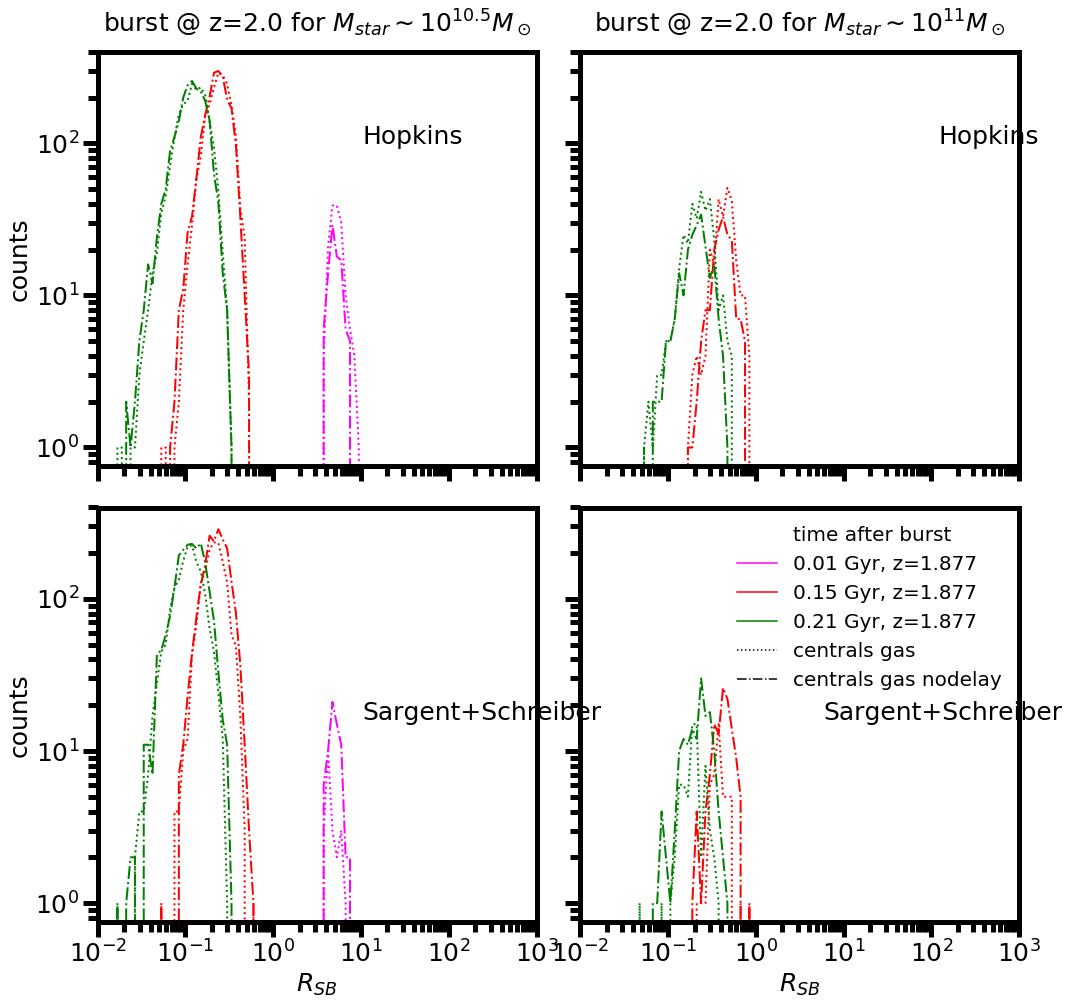

In [37]:
z=2.0
Lbox=250
a=50000

tb=1. #Gyr
array_times_out = np.array([tb*0.01,tb*0.05,tb*0.1,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75])#,tb])             


cosmo_times_out = Cosmo.lookbackTime(z)-array_times_out
cosmo_z_out = Cosmo.lookbackTime(cosmo_times_out, inverse=True)

js=[0,3,5]
cosmo_z_out = np.array([cosmo_z_out[0],cosmo_z_out[3],cosmo_z_out[5]])

massCut_up = [10.7,11.2]
massCut_low = [10.3,10.8]
cols = ['magenta','red','green','navy','pink']
fileshop = ['./quick_output/sSFR_MSS15z2.0_hopkins_fgas_cen.npy','./quick_output/sSFR_MSS15z2.0_hopkins_fgas_cen_nodelay.npy']
filesmock = ['./quick_output/sSFR_MSS15z2.0fgas_cen.npy','./quick_output/sSFR_MSS15z2.0fgas_cen_nodelay.npy']

fig,ax = plt.subplots(2,2,figsize=(16,16),sharex=True,sharey=True)
ax[1][1].plot(np.arange(a,2*a), np.zeros(a),color='white', label='time after burst')

k=0
liness = [':','-.']
strings = ['centrals gas','centrals gas nodelay']
for mup,mlow in zip(massCut_up,massCut_low):
    
    b = np.ma.masked_inside(mstar_bins_new, mlow,mup).mask

    

    m=0
    for  zz,j in zip(cosmo_z_out,js):
        
        for ls,(filehop, filemock) in zip(liness,zip(fileshop,filesmock)):
            sSFR_MS_mock = np.load(filemock)
            sSFR_MS_hop = np.load(filehop)
            
    
            sSFR_burst_MS_mock =np.zeros(sSFR_MS_mock[j][b].shape[1])
            sSFR_burst_MS_hop =np.zeros(sSFR_MS_hop[j][b].shape[1])

            for  i  in range(len(sSFR_MS[j][b])):
                sSFR_burst_MS_mock = sSFR_burst_MS_mock + sSFR_MS_mock[j][b][i]
                sSFR_burst_MS_hop = sSFR_burst_MS_hop + sSFR_MS_hop[j][b][i]
        
#        num = np.sum(sSFR_burst_MS)
#        den = np.sum(sSFR_MS_check-num)
#        frac = num /den
 #       print(frac)
            try:
                ax[0][k].plot(10**ssfr_bins_MS_new,sSFR_burst_MS_mock,color=cols[m],lw=2,ls=ls)
            except:
                pass
            try:
                ax[1][k].plot(10**ssfr_bins_MS_new, sSFR_burst_MS_hop, color=cols[m],lw=2,ls=ls)
            except:
                pass
        m=m+1
        ax[0][k].set_yscale('log')
        ax[1][k].set_xscale('log')
    k=k+1
m=0
for j in js:
    ax[1][1].plot(np.arange(a,2*a), np.zeros(a),color=cols[m], label=str(array_times_out[j])+' Gyr, z='+str(round(zz,3)))
    m=m+1
    

for ls,string in zip(liness,strings):
    ax[1][1].plot(np.arange(a,2*a), np.zeros(a),color='black', ls=ls,label=string)

    
ax[1][1].legend(frameon=False,fontsize=20)
ax[0][1].set_title('burst @ z='+str(z)+' for $M_{star} \sim 10^{11}  M_\odot$',fontsize=25)
ax[0][0].set_title('burst @ z='+str(z)+' for $M_{star} \sim 10^{10.5}  M_\odot$',fontsize=25)
ax[1][0].set_xlim(1.e-2,1.e3)
ax[1][1].set_xlim(1.e-2,1.e3)
plt.subplots_adjust(left=0.1,hspace=0.1,wspace=0.1)
fig.text(0.83,0.8,'Hopkins')
fig.text(0.33,0.8,'Hopkins')
fig.text(0.73,0.3,'Sargent+Schreiber')

fig.text(0.33,0.3,'Sargent+Schreiber')
ax[0][0].set_ylabel('counts')
ax[1][0].set_ylabel('counts')
ax[1][0].set_xlabel('$R_{SB}$')
ax[1][1].set_xlabel('$R_{SB}$')
plt.savefig('/home/lz1f17/Pictures/SF_mergers/effect_gas_cen.pdf')

# testing merger rate

(100000.0, 3214946.4854865326)

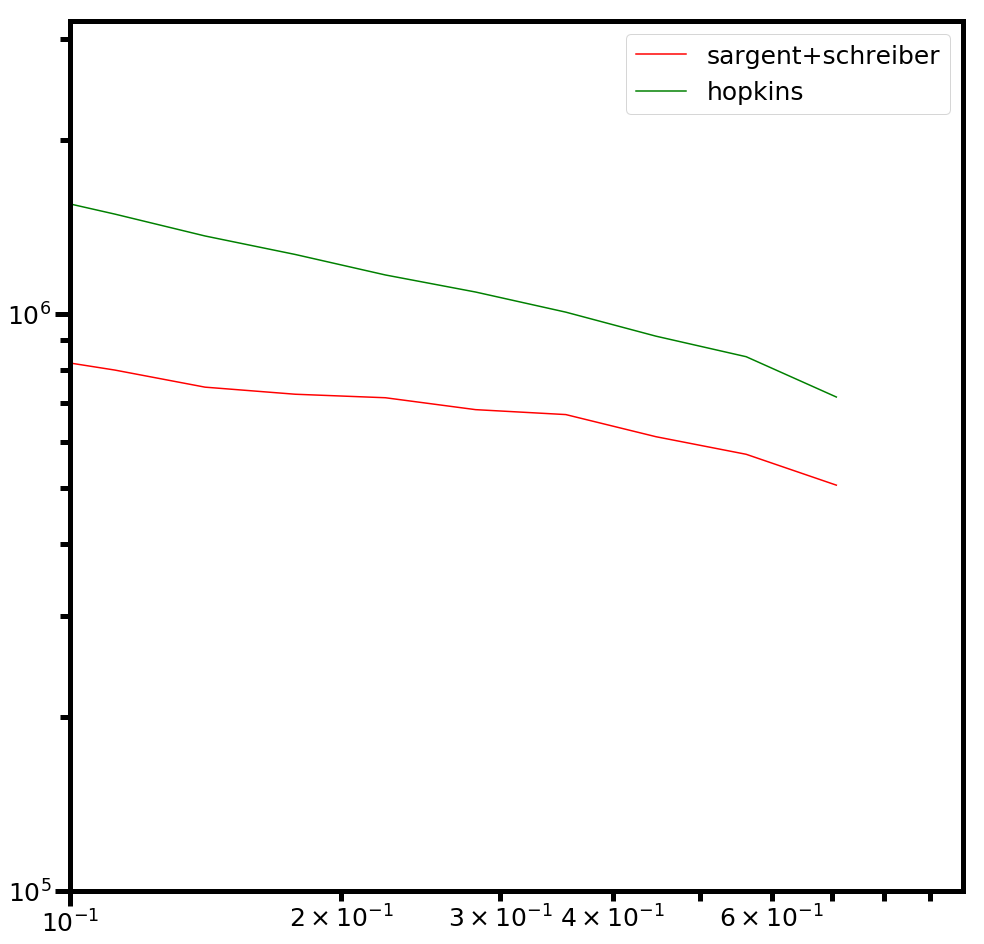

In [20]:
muhop = np.load('./quick_output/muS15z2.0_hopkins.npy')
mu = np.load('./quick_output/muS15z2.0.npy')

plt.plot(10**mu_bins_new,mu/0.01,label='sargent+schreiber',color='red')
plt.plot(10**mu_bins_new,muhop/0.01,label='hopkins',color='green')
plt.legend()
plt.yscale('log')
mask1= np.ma.masked_greater(10**mu_bins_new,0.1).mask
mask3 = np.ma.masked_greater(10**mu_bins_new,0.3).mask
np.sum(mu[mask1]),np.sum(mu[mask3])
plt.xscale('log')
plt.xlim(1.e-1)
plt.ylim(1.e5)

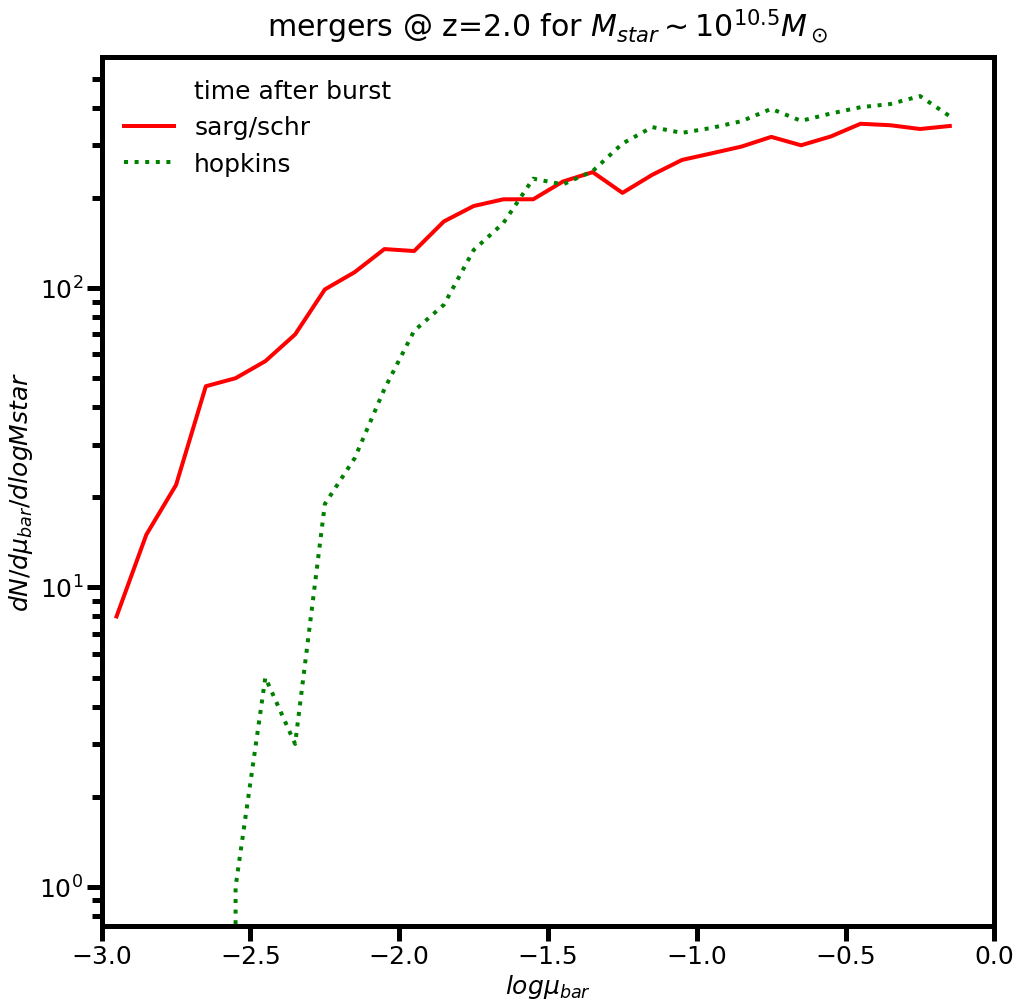

In [40]:
z=2.0
Lbox=250
a=50000

mu = np.load('./quick_output/muS15z'+str(z)+'fgas_cen.npy')
mu_hop = np.load('./quick_output/muS15z'+str(z)+'_hopkins_fgas_cen.npy')

tb=1. #Gyr
array_times_out = np.array([tb*0.01,tb*0.05,tb*0.1,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75])#,tb])             


cosmo_times_out = Cosmo.lookbackTime(z)-array_times_out
cosmo_z_out = Cosmo.lookbackTime(cosmo_times_out, inverse=True)

massCut_up = 11.2
massCut_low =10.8

b = np.ma.masked_inside(mstar_bins_new, massCut_low, massCut_up).mask

plt.plot(np.arange(a,2*a), np.zeros(a),color='white', label='time after burst')

cols = ['magenta','red','green','navy','pink']
m=0

mu_rep =np.zeros(mu[b].shape[1])
mu_rep_hop =np.zeros(mu_hop[b].shape[1])
    #sSFR_MS_check = np.zeros(hist[b].shape[1])
    
for  i  in range(len(mu[b])):
    mu_rep = mu_rep + mu[b][i]
    mu_rep_hop = mu_rep_hop + mu_hop[b][i]
      #  sSFR_MS_check = sSFR_MS_check + hist[b][i]
#    num = np.sum(sSFR_burst_MS)
#    den = np.sum(sSFR_MS_check)
#    frac = num /den
#    print(frac)
#    try:
#        plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS,color=cols[m],\
#                 label=str(array_times_out[j])+' Gyr, z='+str(round(cosmo_z_out[j],3))+', fraction='+str(round(frac,2)),lw=4)
#        plt.plot(10**ssfr_bins_MS_new, sSFR_MS_check, color=cols[m])
#    except:
#        pass
#    m+=1
try:
    plt.plot(mu_bins_new,mu_rep,\
             label='sarg/schr',lw=4,color='red')
    plt.plot(mu_bins_new,mu_rep_hop,\
              label='hopkins',color='green',lw=4, ls=':')
except:
    pass
m+=1

plt.legend(frameon=False)
plt.title('mergers @ z='+str(z)+' for $M_{star} \sim 10^{10.5}  M_\odot$')
plt.xlim(-3,0)
plt.ylim()
plt.ylabel('$dN/d\mu_{bar}/dlogMstar$')
plt.xlabel('$log\mu_{bar}$')
plt.yscale('log')
#plt.xscale('log')
#plt.savefig('/home/lz1f17/Pictures/SF_mergers/mergers_mu_m10.5.pdf')

# Effects of (1-fgas)

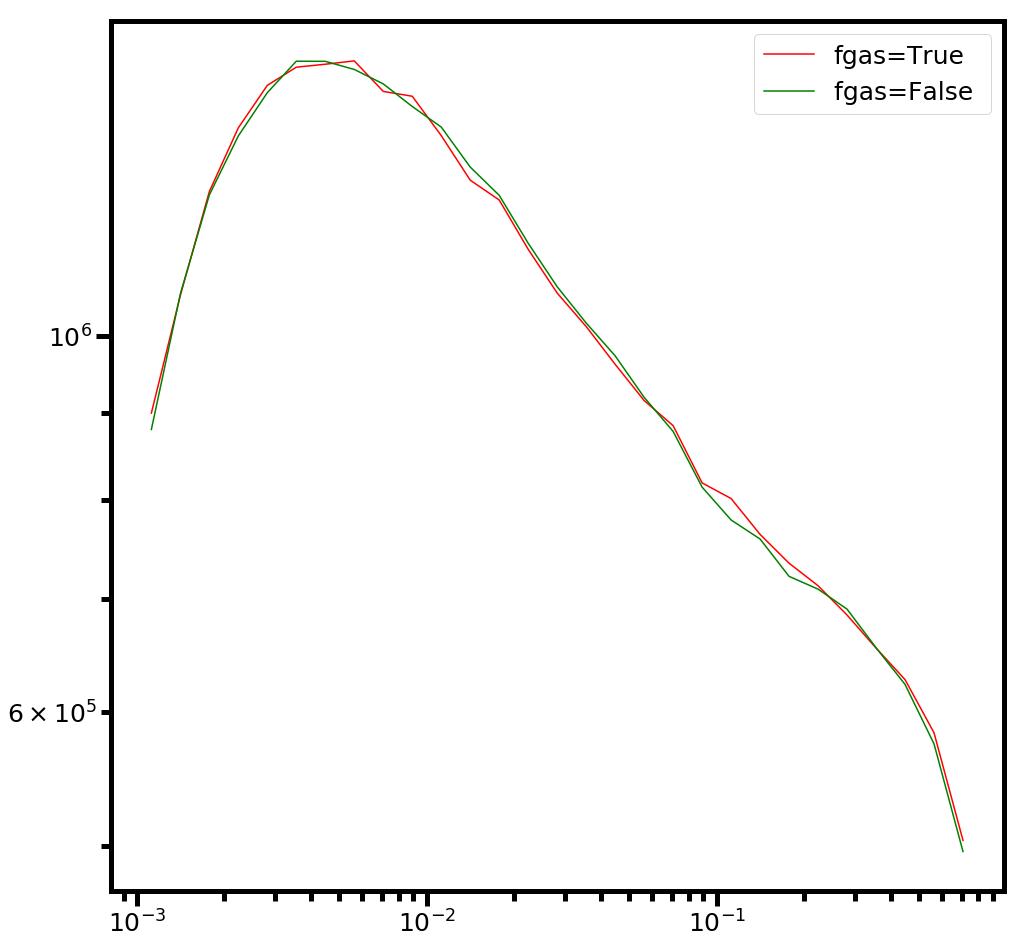

In [23]:
mu = np.load('./quick_output/muS15z2.0fgas.npy')
mu_no = np.load('./quick_output/muS15z2.0no_fgas.npy')

plt.plot(10**mu_bins_new,mu/0.01,label='fgas=True',color='red')
plt.plot(10**mu_bins_new,mu_no/0.01,label='fgas=False ',color='green')
plt.legend()
plt.yscale('log')
mask1= np.ma.masked_greater(10**mu_bins_new,0.1).mask
mask3 = np.ma.masked_greater(10**mu_bins_new,0.3).mask
np.sum(mu[mask1]),np.sum(mu[mask3])
plt.xscale('log')
#plt.xlim(1.e-1)
#plt.ylim(1.e5)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  8.  8. 10.  8.  1.  3.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   6.   5.
  27.  44.  86. 117. 116. 124.  89.  80.  40.  28.   5.   1.   2.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 

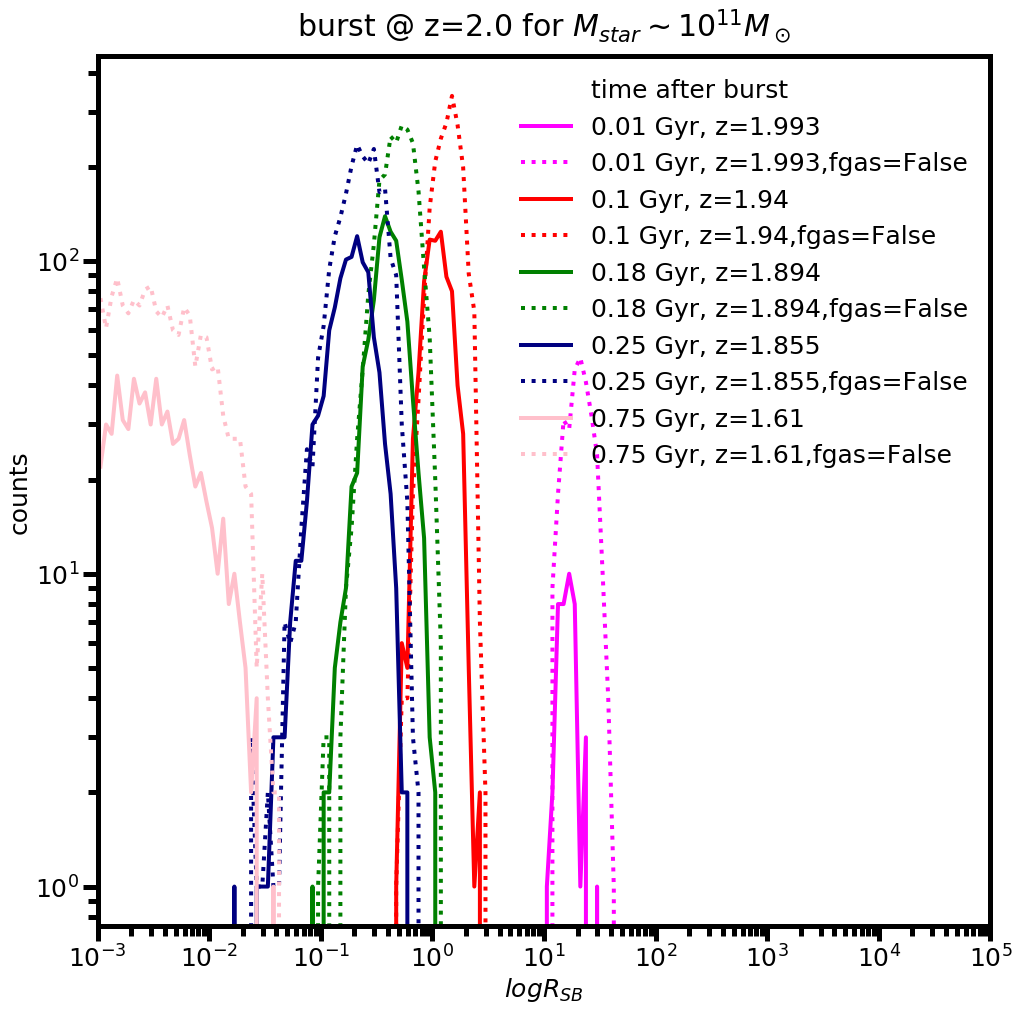

In [38]:
z=2.0
Lbox=250
a=50000

sSFR_MS = np.load('./quick_output/sSFR_MSS15z'+str(z)+'fgas.npy')
sSFR_MS_no = np.load('./quick_output/sSFR_MSS15z'+str(z)+'no_fgas.npy')

tb=1. #Gyr
array_times_out = np.array([tb*0.01,tb*0.05,tb*0.1,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75])#,tb])             


cosmo_times_out = Cosmo.lookbackTime(z)-array_times_out
cosmo_z_out = Cosmo.lookbackTime(cosmo_times_out, inverse=True)

massCut_up = 11.2
massCut_low =10.8

b = np.ma.masked_inside(mstar_bins_new, massCut_low, massCut_up).mask

plt.plot(np.arange(a,2*a), np.zeros(a),color='white', label='time after burst')

cols = ['magenta','red','green','navy','pink']
m=0
for j in range(sSFR_MS.shape[0]-5):
    j=2*j
    
  #  mstar_cen,mgas_cen,SFR_cen,halos = make_mock(cosmo_z_out[j],Lbox)
   
   # SFR_MS_mean = F.StarFormationRate(mstar_cen,cosmo_z_out[j], Paramaters['SFR_Model'], ScatterOn=False)
   
   # sSFR_MS_mock = SFR_cen-SFR_MS_mean
    
   # hist = np.histogram2d(mstar_cen, sSFR_MS_mock, bins =(mstar_bins,ssfr_bins_MS))[0]
    
    sSFR_burst_MS =np.zeros(sSFR_MS[j][b].shape[1])
    sSFR_burst_MS_no =np.zeros(sSFR_MS_no[j][b].shape[1])
    #sSFR_MS_check = np.zeros(hist[b].shape[1])
    
    for  i  in range(len(sSFR_MS[j][b])):
        sSFR_burst_MS = sSFR_burst_MS + sSFR_MS[j][b][i]
        sSFR_burst_MS_no = sSFR_burst_MS_no + sSFR_MS_no[j][b][i]
      #  sSFR_MS_check = sSFR_MS_check + hist[b][i]
#    num = np.sum(sSFR_burst_MS)
#    den = np.sum(sSFR_MS_check)
#    frac = num /den
#    print(frac)
#    try:
#        plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS,color=cols[m],\
#                 label=str(array_times_out[j])+' Gyr, z='+str(round(cosmo_z_out[j],3))+', fraction='+str(round(frac,2)),lw=4)
#        plt.plot(10**ssfr_bins_MS_new, sSFR_MS_check, color=cols[m])
#    except:
#        pass
#    m+=1
    try:
        plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS,color=cols[m],\
                 label=str(array_times_out[j])+' Gyr, z='+str(round(cosmo_z_out[j],3)),lw=4)

        plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS_no,color=cols[m],\
                 label=str(array_times_out[j])+' Gyr, z='+str(round(cosmo_z_out[j],3))+',fgas=False',lw=4, ls=':')
    except:
        pass
    m+=1

plt.legend(frameon=False)
plt.title('burst @ z='+str(z)+' for $M_{star} \sim 10^{11}  M_\odot$')
plt.xlim(1.e-3,1.e5)
plt.ylim()
plt.ylabel('counts')
plt.xlabel('$logR_{SB}$')
plt.yscale('log')
plt.xscale('log')
plt.savefig('/home/lz1f17/Pictures/SF_mergers/m11_burst_ev_z'+str(z)+'_threshmerg_0.1_gas_comparison.pdf')


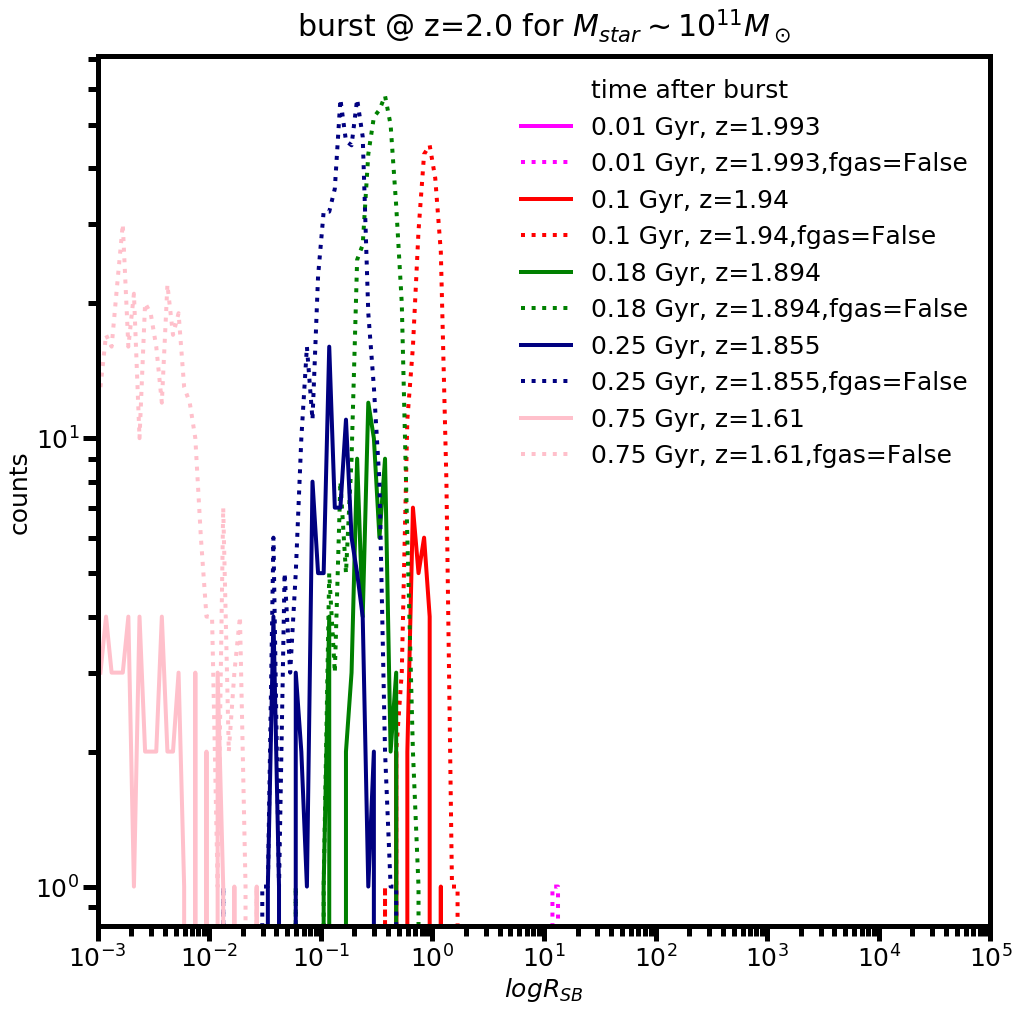

In [27]:
z=2.0
Lbox=250
a=50000

sSFR_MS = np.load('./quick_output/sSFR_MSS15z'+str(z)+'_hopkins_fgas.npy')
sSFR_MS_no = np.load('./quick_output/sSFR_MSS15z'+str(z)+'_hopkins_no_fgas.npy')

tb=1. #Gyr
array_times_out = np.array([tb*0.01,tb*0.05,tb*0.1,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75])#,tb])             


cosmo_times_out = Cosmo.lookbackTime(z)-array_times_out
cosmo_z_out = Cosmo.lookbackTime(cosmo_times_out, inverse=True)

massCut_up = 10.8
massCut_low =11.2

b = np.ma.masked_inside(mstar_bins_new, massCut_low, massCut_up).mask

plt.plot(np.arange(a,2*a), np.zeros(a),color='white', label='time after burst')

cols = ['magenta','red','green','navy','pink']
m=0
for j in range(sSFR_MS.shape[0]-5):
    j=2*j
    
  #  mstar_cen,mgas_cen,SFR_cen,halos = make_mock(cosmo_z_out[j],Lbox)
   
   # SFR_MS_mean = F.StarFormationRate(mstar_cen,cosmo_z_out[j], Paramaters['SFR_Model'], ScatterOn=False)
   
   # sSFR_MS_mock = SFR_cen-SFR_MS_mean
    
   # hist = np.histogram2d(mstar_cen, sSFR_MS_mock, bins =(mstar_bins,ssfr_bins_MS))[0]
    
    sSFR_burst_MS =np.zeros(sSFR_MS[j][b].shape[1])
    sSFR_burst_MS_no =np.zeros(sSFR_MS_no[j][b].shape[1])
    #sSFR_MS_check = np.zeros(hist[b].shape[1])
    
    for  i  in range(len(sSFR_MS[j][b])):
        sSFR_burst_MS = sSFR_burst_MS + sSFR_MS[j][b][i]
        sSFR_burst_MS_no = sSFR_burst_MS_no + sSFR_MS_no[j][b][i]
      #  sSFR_MS_check = sSFR_MS_check + hist[b][i]
        
#    num = np.sum(sSFR_burst_MS)
#    den = np.sum(sSFR_MS_check)
#    frac = num /den
#    print(frac)
#    try:
#        plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS,color=cols[m],\
#                 label=str(array_times_out[j])+' Gyr, z='+str(round(cosmo_z_out[j],3))+', fraction='+str(round(frac,2)),lw=4)
#        plt.plot(10**ssfr_bins_MS_new, sSFR_MS_check, color=cols[m])
#    except:
#        pass
#    m+=1
    try:
        plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS,color=cols[m],\
                 label=str(array_times_out[j])+' Gyr, z='+str(round(cosmo_z_out[j],3)),lw=4)

        plt.plot(10**ssfr_bins_MS_new,sSFR_burst_MS_no,color=cols[m],\
                 label=str(array_times_out[j])+' Gyr, z='+str(round(cosmo_z_out[j],3))+',fgas=False',lw=4, ls=':')
    except:
        pass
    m+=1

plt.legend(frameon=False)
plt.title('burst @ z='+str(z)+' for $M_{star} \sim 10^{11}  M_\odot$')
plt.xlim(1.e-3,1.e5)
plt.ylim()
plt.ylabel('counts')
plt.xlabel('$logR_{SB}$')
plt.yscale('log')
plt.xscale('log')
plt.savefig('/home/lz1f17/Pictures/SF_mergers/m11_burst_ev_z'+str(z)+'_threshmerg_0.1_gas_comparison_hopkins.pdf')


In [55]:
mstar_cen,mgas_cen,SFR_cen,halos = make_mock(z,Lbox)
mask_mock = np.ma.masked_inside(mstar_cen, massCut_low, massCut_up).mask
sSFR_MS = np.log10(10**SFR_cen[mask_mock]/10**mstar_cen[mask_mock])
SFR_MS = SFR_cen[mask_mock]

In [56]:
merging_galaxies = np.sum(sSFR_burst_MS).astype(int)
indices_delete = np.random.uniform(0,len(sSFR_MS), size = merging_galaxies).astype(int)
sSFR_MS = np.delete(sSFR_MS, indices_delete)

In [57]:
merging_galaxies/len(sSFR_MS)

1.393854748603352

In [139]:
#hist_mock = np.histogram(sSFR_MS,bins=ssfr_bins)[0]

sSFR_mean_MS = np.percentile(sSFR_MS,50)

sSFR_burst_MS = sSFR_burst/sSFR_mean_MS  #DOESN'T WORK; YOU NEED TO DO IT IN THE QUICK TEST!!

1.4564492409877566e-09

In [150]:
massCut_up = 11.2
massCut_low =10.8
tb = burst_params['total_time_yr']
array_times_out = np.array([tb*0.01,tb*0.05,tb*0.10,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75,tb]) 

In [ ]:
### here will go the full analysis once I have run the quick_test at different adhiacent redshift
for i in range(len(array_times_out)):
    
    
    mstar_cen,mgas_cen,SFR_cen,halos = make_mock(z,Lbox)

    mask_mock = np.ma.masked_inside(mstar_cen, massCut_low, massCut_up).mask

    sSFR_mock = SFR_cen[mask_mock]/mstar_cen[mask_mock]


In [125]:
def burst_history_log(x,t0,M0):
    mtilde = M0/t0
    return t0*np.log(10)*np.e**(-x/mtilde)

# test hopkins model

(5.9615166291371385e-12, 2282.4396214903713)

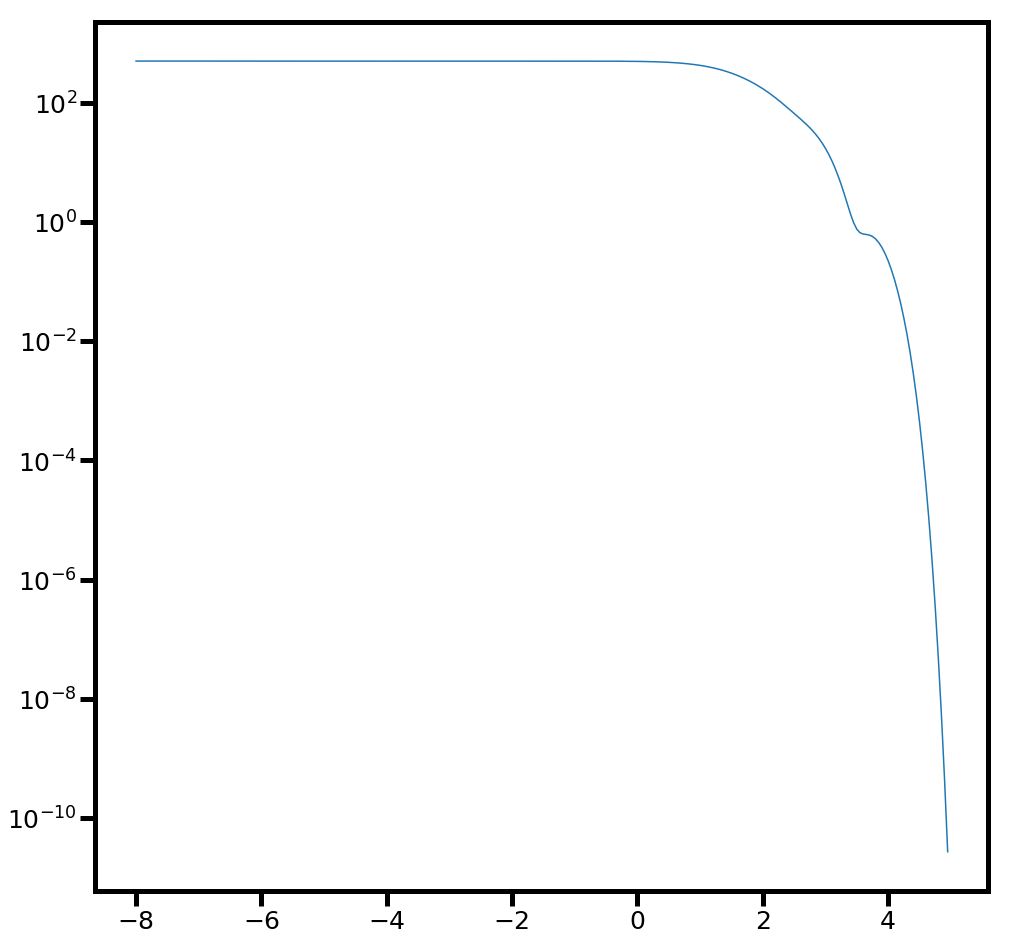

In [171]:
dndlogmdot = np.load('./quick_output/dndlogmdot_10.5_10.8.npy')

dndlogmdot_t0 = np.zeros(np.shape(dndlogmdot)[0])

app = dndlogmdot[0].T

res = np.sum(app.T, axis=1)

res[res<0] =0
plt.plot(sfr_bins, res)
plt.yscale('log')
plt.ylim()


In [172]:
dndlogmdot

array([[[-3.60776961,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-3.60776961,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-3.6077696 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  2.07488806,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  2.07488805,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  2.07488805,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

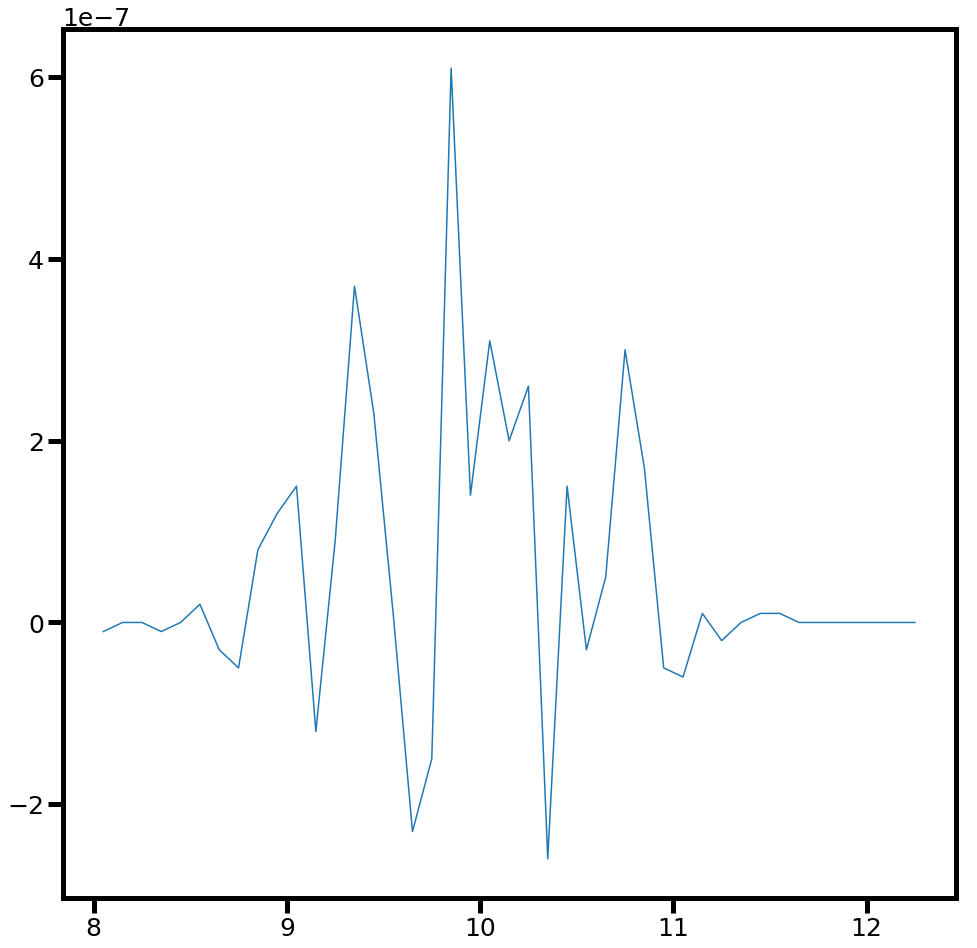

In [17]:
dndt = np.load('./quick_output/dndt_10.5_10.8.npy')

dndt_t0 = np.zeros(np.shape(dndt)[0])

app = dndt[0].T

plt.plot(burst_bins_,dndt[0])


In [16]:
        burst_bin_width =0.1
        burst_bins =np.arange(8,12.3,burst_bin_width)
        burst_bins_ = burst_bins[1:]-burst_bin_width/2.

In [173]:
dndt

array([[-1.0e-08,  0.0e+00,  0.0e+00, -1.0e-08,  0.0e+00,  2.0e-08,
        -3.0e-08, -5.0e-08,  8.0e-08,  1.2e-07,  1.5e-07, -1.2e-07,
         9.0e-08,  3.7e-07,  2.3e-07,  1.0e-08, -2.3e-07, -1.5e-07,
         6.1e-07,  1.4e-07,  3.1e-07,  2.0e-07,  2.6e-07, -2.6e-07,
         1.5e-07, -3.0e-08,  5.0e-08,  3.0e-07,  1.7e-07, -5.0e-08,
        -6.0e-08,  1.0e-08, -2.0e-08,  0.0e+00,  1.0e-08,  1.0e-08,
         0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,
         0.0e+00],
       [ 0.0e+00,  1.0e-08,  0.0e+00,  5.0e-08,  0.0e+00, -5.0e-08,
         7.0e-08,  1.0e-07,  2.0e-08,  1.0e-08,  4.0e-08,  2.2e-07,
         1.6e-07,  1.0e-08,  2.2e-07,  2.3e-07,  8.7e-07,  4.8e-07,
        -2.8e-07,  3.0e-08,  9.0e-08, -1.1e-07, -1.0e-07,  5.0e-08,
         2.0e-08, -2.8e-07,  6.0e-08, -1.2e-07, -1.1e-07,  0.0e+00,
         4.0e-08,  1.0e-08,  0.0e+00,  1.0e-08, -1.0e-08, -1.0e-08,
         0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,
         0.0e+00],
       [ 1

In [134]:
        ss = np.tile(10**sfr_bins, (len(burst_bins)-1,1) )
        bb =10**(burst_bins[1:]-burst_bin_width/2.)  
        times = 10**np.random.normal(np.log10(burst_params['tburst_yr']),0.1, size=len(burst_bins))
        burst_law = np.array(list(map( lambda x,y,z:  burst_history_log(x,burst_params['tburst_yr'], y), *[ss,bb,times])))

In [ ]:
law

In [135]:
burst_law.shape

(43, 260)

In [192]:
dndt0 = dndt[0]

Mb = np.tile(dndt0,(260,1))

In [178]:
res=np.array(list(map(lambda x,y: x*y, *[Mb.T,burst_law])))

In [198]:
Mb[0]

array([-1.0e-08,  0.0e+00,  0.0e+00, -1.0e-08,  0.0e+00,  2.0e-08,
       -3.0e-08, -5.0e-08,  8.0e-08,  1.2e-07,  1.5e-07, -1.2e-07,
        9.0e-08,  3.7e-07,  2.3e-07,  1.0e-08, -2.3e-07, -1.5e-07,
        6.1e-07,  1.4e-07,  3.1e-07,  2.0e-07,  2.6e-07, -2.6e-07,
        1.5e-07, -3.0e-08,  5.0e-08,  3.0e-07,  1.7e-07, -5.0e-08,
       -6.0e-08,  1.0e-08, -2.0e-08,  0.0e+00,  1.0e-08,  1.0e-08,
        0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00,
        0.0e+00])

In [199]:
burst_law

array([[2.30258507e+08, 2.30258507e+08, 2.30258507e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.30258508e+08, 2.30258507e+08, 2.30258507e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.30258508e+08, 2.30258508e+08, 2.30258508e+08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.30258509e+08, 2.30258509e+08, 2.30258509e+08, ...,
        4.18796225e+05, 1.93930542e+05, 8.17507973e+04],
       [2.30258509e+08, 2.30258509e+08, 2.30258509e+08, ...,
        1.53315897e+06, 8.31760599e+05, 4.18796225e+05],
       [2.30258509e+08, 2.30258509e+08, 2.30258509e+08, ...,
        4.29791889e+06, 2.64419510e+06, 1.53315897e+06]])

In [181]:
dndt0.shape

(43,)